In [ ]:
import numpy as np 
import math 
import os 
import matplotlib.pyplot as plt
from itertools import product, combinations
import multiprocessing as mp

from scipy.interpolate import griddata
from matplotlib.colors import Normalize
os.getcwd()

A program for overlapped volume from hard sphere approximation in crystal lattice. (Acta Metall., **15(3)**, 459 (1967)) Take Cr3Si [mp-729](https://next-gen.materialsproject.org/materials/mp-729?formula=Cr3Si) as example, 2D unit cell of arbitrary slip plane can be derived use some linear algebra.

In [5]:
# # #* Pauling radii
# r_cr = 1.357e2
# r_si = 1.316e2

# #* reference
# r_cr = 1.29e2 #* metallic
# r_si = 1.18e2 #* colvalent

#* Wigner-Seitz radius
r_cr = 1.285 #* Cr_sv_new
r_si = 1.312 #* Si

lp = 4.48123895
lp_vec = np.array([9.76663386, 6.3374289, 1]) #* 6 -1 -1
# lp_vec = np.array([lp, 18.47662152, 1]) #* 4 0 1
# lp_vec = np.array([lp, lp, 1]) #* 0 0 1
threshold = 0
p_norm_denote = '6_-1_-1' #TODO slip plane

def spherical_cap(r, theta):
    return np.pi/3*r**3*(2+np.cos(theta))*(1-np.cos(theta))**2

def pbc_2d(c_raw, lp_vec):
    '''
    for 2d square lattice's pbc
    '''
    c_raw_n = np.empty((0,3))
    for i, j in product([-2, -1, 0, 1], repeat=2):
        c_raw_n = np.concatenate((c_raw_n, c_raw+np.array([i,j,0])*lp_vec), axis=0)
    
    return c_raw_n

def angle_calc(l1, l2, d):
    try:
        angle_l2 = math.acos((d**2 + l2**2 - l1**2) / (2 * d * l2))
        angle_l1 = math.acos((d**2 + l1**2 - l2**2) / (2 * d * l1))
    except:
        print(d, l1, l2)
    
    return angle_l1, angle_l2

#* fractional coordinate
pth_base = 'cr3si'
l1_cr_cart = np.load(pth_base+f'/l1_cr_cart_{threshold}_{p_norm_denote}.npy')
l1_si_cart = np.load(pth_base+f'/l1_si_cart_{threshold}_{p_norm_denote}.npy')
l2_cr_cart = np.load(pth_base+f'/l2_cr_cart_{threshold}_{p_norm_denote}.npy')
l2_si_cart = np.load(pth_base+f'/l2_si_cart_{threshold}_{p_norm_denote}.npy')

l1_cart = np.concatenate((l1_cr_cart, l1_si_cart), axis=0)
l2_cart = np.concatenate((l2_cr_cart, l2_si_cart), axis=0)
l2_cart = pbc_2d(l2_cart, lp_vec) #* make 2d pbc to avoid discrepancy

#* Ising-like spin sequence
embed_dict = {
    1: r_cr,
    -1: r_si,
}

l1_seq = np.concatenate((np.ones(len(l1_cr_cart))*1,
                         np.ones(len(l1_si_cart))*-1))
l2_seq = np.concatenate((np.ones(len(l2_cr_cart))*1,
                         np.ones(len(l2_si_cart))*-1))
l2_seq = np.tile(l2_seq, 16)

#* prepare displacement grid
dx_grid, dy_grid = \
    np.linspace(0, lp_vec[0], 101), \
    np.linspace(0, lp_vec[1], 101)
dxy = np.array([[i,j] for i, j in product(dx_grid, dy_grid)])


def main(i):
    d_i = dxy[i]
    v = 0
    l2_cart_, l2_seq_ = l2_cart.copy(), l2_seq.copy()
    l1_cart_, l1_seq_ = l1_cart.copy(), l1_seq.copy()
    
    l2_cart_[:,:2] = l2_cart_[:,:2] + d_i
    
    for l2_c, l2_spin in zip(l2_cart_, l2_seq_):
        for l1_c, l1_spin in zip(l1_cart_, l1_seq_):
            
            l2_r, l1_r = embed_dict[l2_spin], embed_dict[l1_spin]
            d = np.linalg.norm(l2_c-l1_c)
            if d >= l2_r + l1_r:
                continue
            
            l1_angle, l2_angle = angle_calc(l1_r, l2_r, d)
            cap_l1 = spherical_cap(l1_r, l1_angle)
            cap_l2 = spherical_cap(l2_r, l2_angle)
            v += (cap_l1+cap_l2)
            
    return d_i[0], d_i[1], v

v0 = main(0)[2]
p = mp.Pool(16)
result = p.map(main, range(len(dxy)))
dxy = np.array([[r[0], r[1]] for r in result])
dv = np.array([r[2] for r in result])
dv = (np.array(dv)-v0)/(lp_vec[0]*lp_vec[1])

(array([ 22.,  18.,  17.,  19.,  18.,  11.,  26.,  13.,  15.,  22.,  22.,
         11.,  25.,  19.,  18.,  18.,  25.,  23.,  21.,  16.,  25.,  27.,
         18.,  28.,  26.,  20.,  25.,  31.,  33.,  19.,  35.,  26.,  35.,
         31.,  31.,  31.,  31.,  46.,  36.,  46.,  39.,  46.,  56.,  65.,
         61.,  70.,  66.,  81.,  69.,  71., 106., 145., 146., 152., 206.,
        256., 272., 303., 278., 261., 259., 275., 248., 250., 276., 237.,
        236., 208., 261., 336., 282., 269., 284., 312., 284., 231., 214.,
        219., 188., 175., 172., 140., 132., 101., 121.,  98., 103.,  85.,
         92.,  92.,  61.,  48.,  35.,  26.,  27.,  17.,  23.,  13.,  15.,
         14.,  14.]),
 array([-2.61805172e-04,  2.67647113e-03,  5.61474743e-03,  8.55302373e-03,
         1.14913000e-02,  1.44295763e-02,  1.73678526e-02,  2.03061289e-02,
         2.32444052e-02,  2.61826815e-02,  2.91209578e-02,  3.20592341e-02,
         3.49975104e-02,  3.79357867e-02,  4.08740630e-02,  4.38123393e-02,
        

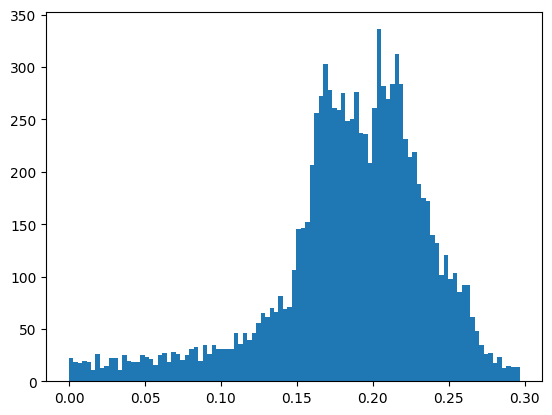

In [6]:
plt.hist(dv, len(dx_grid))

/var/folders/9l/70dz0y490f36d9gvpppwgrfc0000gn/T/ipykernel_93967/1458493255.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r')


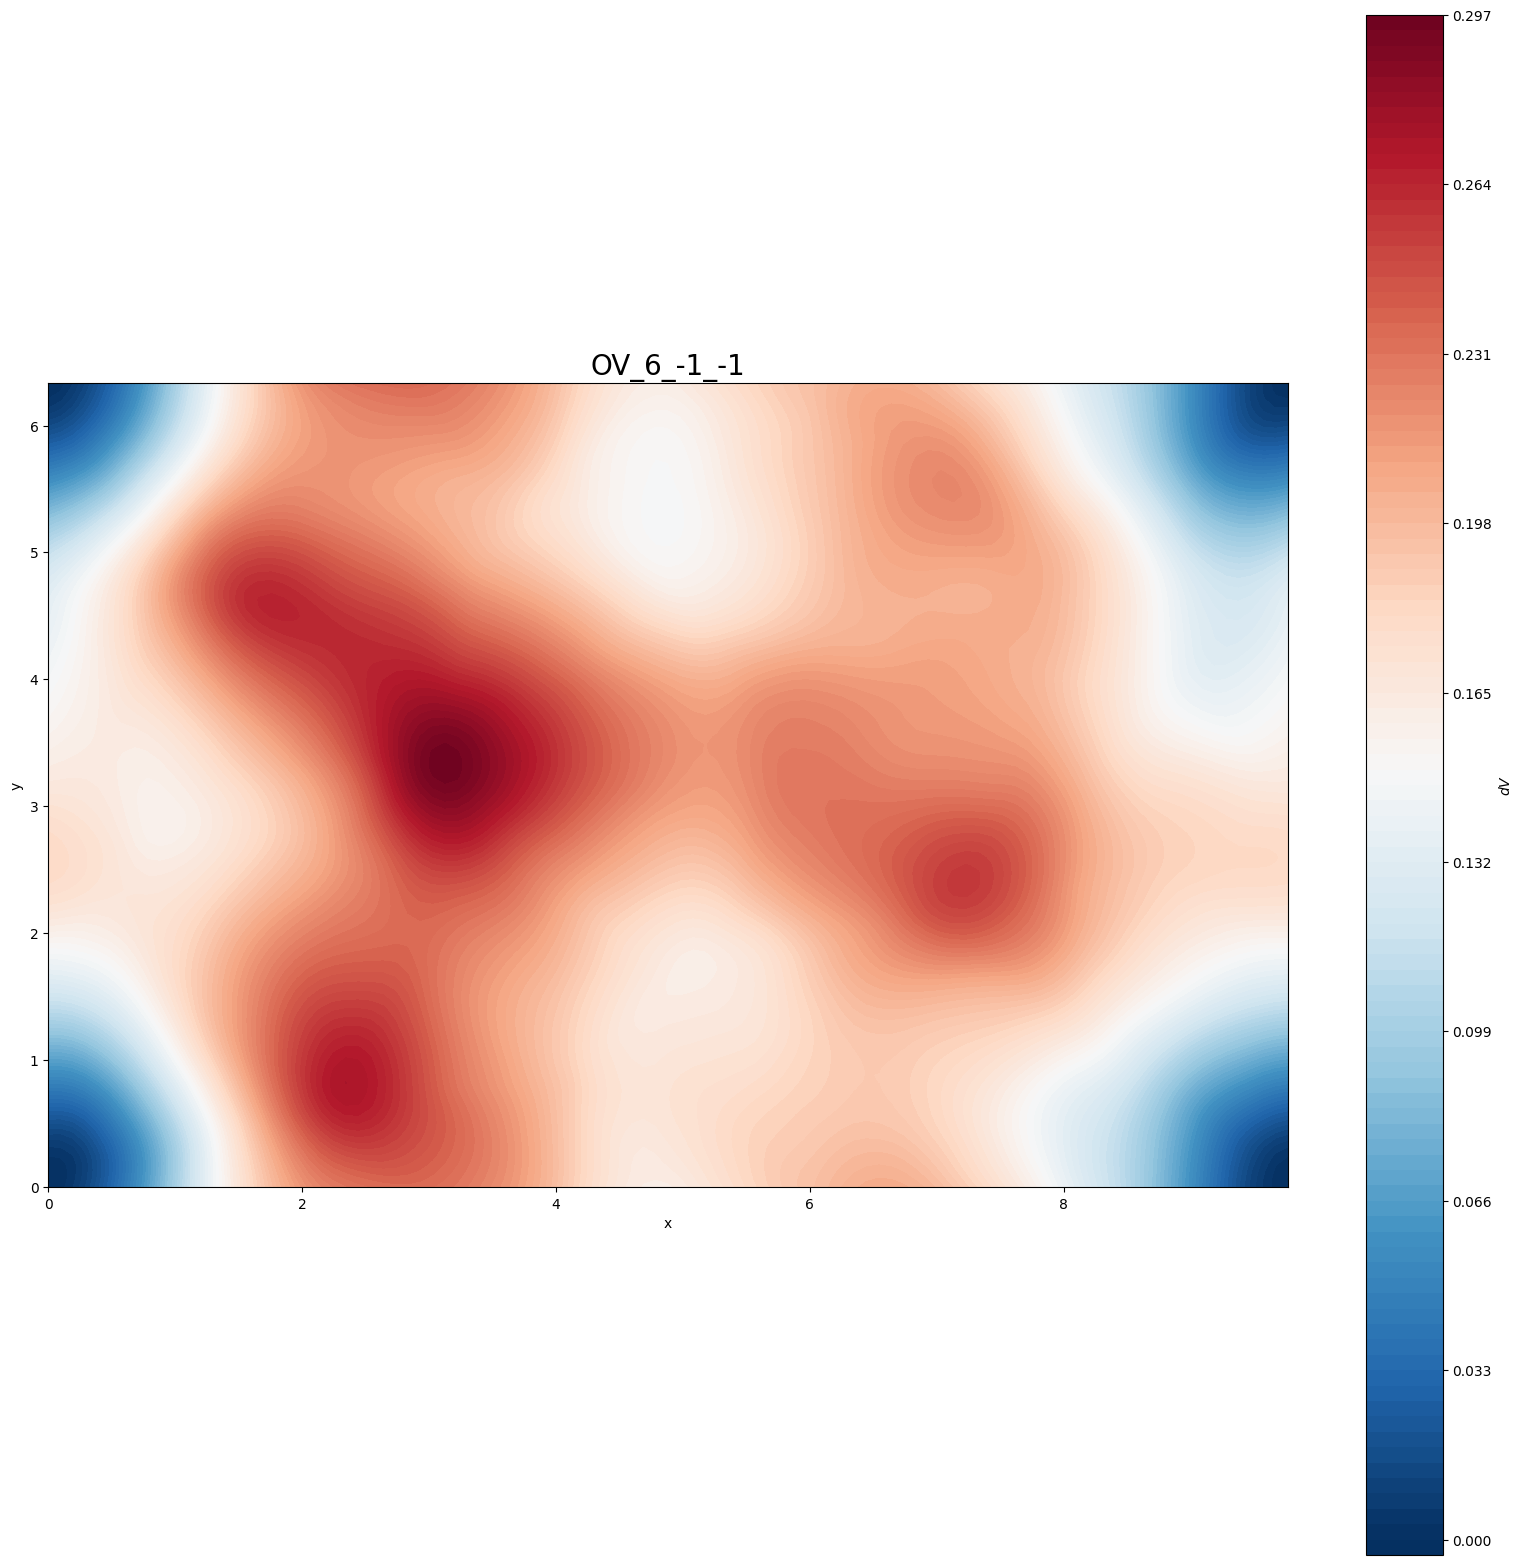

In [7]:
x, y, z = dxy[:,0], dxy[:,1], dv

xi = np.linspace(min(x), max(x), len(dx_grid))
yi = np.linspace(min(y), max(y), len(dy_grid))
xi, yi = np.meshgrid(xi, yi)

zi = griddata((x, y), z, (xi, yi), method='linear')
cmap = plt.cm.get_cmap('RdBu_r')
norm = Normalize(vmin=0, vmax=0.3)

plt.figure(figsize=(20, 20))
plt.contourf(xi, yi, zi, levels=100, cmap=cmap, norm=norm)
plt.colorbar(label='$dV$')
plt.title(f'OV_{p_norm_denote}', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')

plt.axis('scaled')
plt.show()